In [2]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [31]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [6]:
class CustomDataset(Dataset):
  def __init__(self,depth,data_type='train'):
    super(CustomDataset, self).__init__()
    self.x = []
    self.y = []

    data = np.genfromtxt('./data.txt', delimiter=' ')
    if data_type == 'train':
      for i in range(depth, len(data) - 1):
        self.x.append(data[i-depth:i,0:4])
        self.y.append(data[i,3])
      self.x = torch.tensor(np.array(self.x))
      self.y = torch.tensor(np.array(self.y))
    elif data_type == 'test':
      for i in range(depth, len(data) - 1):
        self.x.append(data[i-depth:i,4:8])
        self.y.append(data[i,7])
      self.x = torch.tensor(np.array(self.x))
      self.y = torch.tensor(np.array(self.y))
    else:
      raise Exception('Invalid data type.')

  def __getitem__(self, index):
    return self.x[index].float(), self.y[index].float()
  
  def __len__(self):
    return len(self.x)

dataset = CustomDataset(depth=5, data_type='train')
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [21]:
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    
    self.num_classes = num_classes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    h0 = torch.autograd.Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
    c0 = torch.autograd.Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

    output , (h_out, c_out) = self.lstm(x, (h0, c0))
    h_out = h_out.view(-1, self.hidden_size)

    out = self.fc(h_out)
    return out.float()

In [22]:
model = LSTM(num_classes=1, input_size=4, hidden_size=10, num_layers=1).float()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


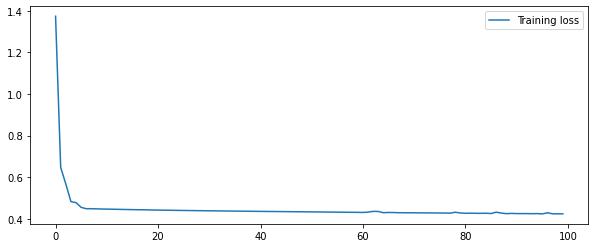

In [23]:
train_history = np.zeros(100)

for epoch in range(100):
  avg_loss = 0
  for i, data in enumerate(dataloader):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs.float())
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    avg_loss += loss/32
  train_history[epoch] = avg_loss

fig = plt.figure(figsize=(10, 4))
plt.plot(train_history, label='Training loss')
plt.legend()
plt.show()

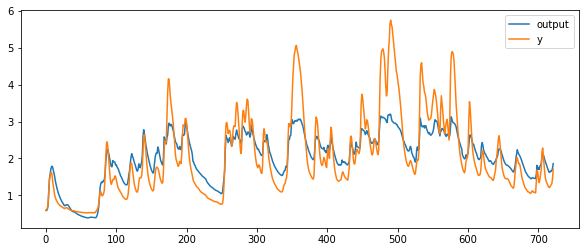

In [30]:
dataset = CustomDataset(depth=5,data_type='test')

p1 = []
p2 = []

for i in range(len(dataset)):
  x, y = dataset.__getitem__(i)
  x = torch.reshape(x, (1, 5, 4))
  output = model(x)
  output = torch.reshape(output, (1,))
  p1.append(output.detach().numpy())
  p2.append(y.detach().numpy())

fig = plt.figure(figsize=(10, 4))
plt.plot(p1, label='output')
plt.plot(p2, label='y')
plt.legend()
plt.show()



---



In [ ]:
class CustomLSTM(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(CustomLSTM, self).__init__()

    # input size, hidden size
    self.input_size = input_size
    self.hidden_size = hidden_size

    # gate size
    gate_size = 4 * hidden_size

    # weight
    self.w_ih = nn.Parameter(torch.Tensor(self.input_size, gate_size))
    self.w_hh = nn.Parameter(torch.Tensor(self.hidden_size, gate_size))
    
    # bias
    self.b = nn.Parameter(torch.Tensor(gate_size))

    # weight initialization
    self.init_weights()

  def init_weights(self):
    std = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std)

  def forward(self, x):
    # B : batch size, L : sequence length
    B, L = x.size(0), x.size(1)

    output = []

    h0 = torch.zeros(B, self.hidden_size)
    c0 = torch.zeros(B, self.hidden_size)

    for t in range(L):
      xt = x[:,t,:]
      gates = xt @ self.w_ih + h0 @ self.w_hh + self.b

      it = torch.sigmoid(gates[:,:self.hidden_size])
      ft = torch.sigmoid(gates[:,self.hidden_size:2*self.hidden_size])
      gt = torch.tanh(gates[:,2*self.hidden_size:3*self.hidden_size])
      ot = torch.sigmoid(gates[:,3*self.hidden_size:])

      ct = ft * c0 + it + gt
      ht = ot * torch.tanh(c0)

      # save as B x 1 x h
      output.append(ht.unsqueeze(1))
    
    # output shape : B x L x h
    output = torch.cat(output, dim=1)
    return output, (ht, ct)

In [ ]:
class SingleStepLSTM(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(SingleStepLSTM, self).__init__()

    self.lstm = CustomLSTM(input_size, hidden_size)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    _, (ht, _) = self.lstm(x)
    output = self.fc(ht)
    return output

In [ ]:
'''
class MultiStepLSTM(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(MultiStepLSTM, self).__init__()

    self.lstm = CustomLSTM(input_size, hidden_size)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    _, (ht, _) = self.lstm(x)
    output1 = self.fc(ht)


    return output1, output2
'''